In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm, trange
import random
import copy
from mpl_toolkits.mplot3d import Axes3D
from multiprocessing import Pool
from collections import deque
from scipy.optimize import curve_fit



# SAW class definition (2D)

In [3]:
# SAW of 2 dimensions
class saw2d():
  def __init__(self):
    self.walked_path = np.array([[0, 0]])
    self.curr_pos = np.array([0, 0])
    self.possible_moves = np.array([[1,  0],
                                    [-1, 0],
                                    [0,  1],
                                    [0, -1]])  
    self.possible_trasforms = [
            # np.array([[1, 0], [0, 1]]),   # Identity
            np.array([[0, 1], [-1, 0]]),  # 90 degrees
            np.array([[0, -1], [1, 0]]),  # -90 degrees (270 degrees)
            np.array([[-1, 0], [0, -1]]), # 180 degrees
            np.array([[-1, 0], [0, 1]]),  # Reflection over y-axis
            np.array([[1, 0], [0, -1]]),  # Reflection over x-axis
            np.array([[0, 1], [1, 0]]),   # Reflection over y=x
            np.array([[0, -1], [-1, 0]]), # Reflection over y=-x
        ]

  def step(self):
    '''Takes one step in a random direction, and checks if the resulting walk is valid.
    Returns false if new walk is invalid, and does not take step.
    Returns True and takes a step if the step is valid'''
    next_moves = self.curr_pos + self.possible_moves
    next_pos = next_moves[np.random.choice(len(next_moves))]

    if np.any(np.all(self.walked_path == next_pos, axis=1)):
      return False
    self.curr_pos = next_pos
    self.walked_path = np.vstack([self.walked_path, self.curr_pos])
    return True

  def take_steps(self, N):
    '''Take N steps in succession, repeating each step attempt if it fails.'''
    for n in range(N):
      if not self.step():
        return False
    return True

  def initial_walk(self, length):
    '''Generates a straight-line walk of length N'''
    # generate straight line walk for initial step
    self.walked_path = np.array([[i, 0] for i in range(length+1)])
    self.curr_pos = self.walked_path[-1]
    return

  def plot_walk(self, min_range=-10, max_range=10):
    N = len(self.walked_path)
    x = self.walked_path[:, 0]
    y = self.walked_path[:, 1]
    plt.plot(x, y, marker='',linewidth=3)
    plt.xlabel("X")
    plt.ylabel("Y")
    plt.grid(True, which='both', color='gray', linestyle='--', linewidth=0.5)
    plt.gca().set_aspect('equal', adjustable='box')

    ax_rangex = np.arange(min(min_range, min(x)), max(max_range, max(x)), step=1)
    ax_rangey = np.arange(min(min_range, min(y)), max(max_range, max(y)), step=1)

    plt.gca().set_xticks(ax_rangex)
    plt.gca().set_yticks(ax_rangey)
    plt.show()

  def set_curr_walk(self, new_path):
    self.walked_path = new_path
    self.current_pos = self.walked_path[-1]

  def get_omega2(self):
    start = self.walked_path[0]
    end = self.walked_path[-1]
    omega2 = np.sum((end - start) ** 2)
    return omega2

  def get_S2(self):
    # root mean square distance of the object's parts from its center of mass
    N = len(self.walked_path) - 1 
    path_squared = np.sum(self.walked_path ** 2, axis=1)
    total_squared_sum = np.sum(path_squared)
    total_sum = np.sum(self.walked_path, axis=0)
    squared_total_sum = np.sum(total_sum ** 2)

    S_squared = (1 / (N + 1)) * total_squared_sum - (1 / (N + 1) ** 2) * squared_total_sum
    return S_squared

  def pivot(self):
    '''Attempts to perform one pivot on the current path.
    Returns True if pivot successful and modifies the current path
    Returns False if pivot uncesseful and does not modify self'''
    if len(self.walked_path) < 3:
      print("error: path length < 3")
      return False 

    pivot_index = random.randint(1, len(self.walked_path) - 1)
    pivot_point = self.walked_path[pivot_index]
    transformation = random.choice(self.possible_trasforms)
    # print(f"pivot point: {pivot_point}")
    # print(f"pivot operation: {transformation}")

    new_path = np.empty_like(self.walked_path)
    new_path[:pivot_index + 1] = self.walked_path[:pivot_index + 1]

    vectors = self.walked_path[pivot_index+1:] - pivot_point
    transformed_vecs = vectors @ transformation.T
    new_points = transformed_vecs + pivot_point
    new_path[pivot_index+1:] = new_points

    if self.is_valid_walk(new_path):
      # print("pivot success")
      self.walked_path = new_path
      self.current_pos = self.walked_path[-1]
      return True
    else:
      # print("pivot failed")
      return False

  def is_valid_walk(self, path):
    '''check if pivoted walk is saw'''
    return len(path) == len(set(tuple(p) for p in path))


# Generate samples naively (static)

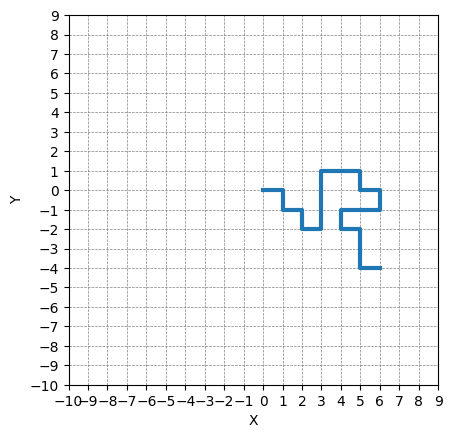

In [16]:
# Visualize one walk
N = 20
saw = saw2d()
res = saw.take_steps(N)
while not res:
    saw = saw2d()
    res = saw.take_steps(N)

saw.plot_walk()
# saw.get_S2()

In [ ]:
N = 15
iters = 10000
omega2_arr = np.zeros(iters)
S2_arr = np.zeros(iters)


for i in trange(iters):
  gen_success = False
  while not gen_success:
    saw = saw2d()
    gen_success = saw.take_steps(N)
  omega2_arr[i] = saw.get_omega2()
  S2_arr[i] = saw.get_S2()
  # saw.plot_walk()

# saw.plot_walk()
print(np.mean(omega2_arr))
print(np.mean(S2_arr))

Naive generation, N=15: 

    omega^2: 47.4708

    S^2: 6.7888328125

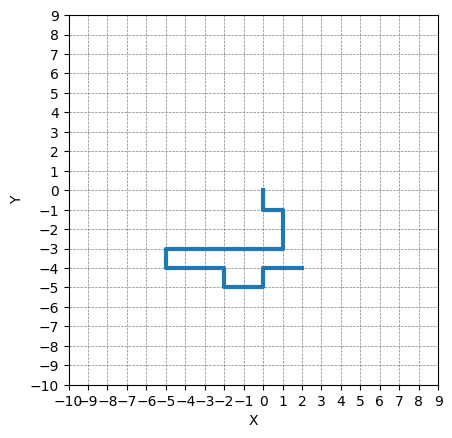

pivot point: [-4 -4]
pivot operation: [[ 1  0]
 [ 0 -1]]
pivot point: [-5 -4]
pivot operation: [[-1  0]
 [ 0  1]]


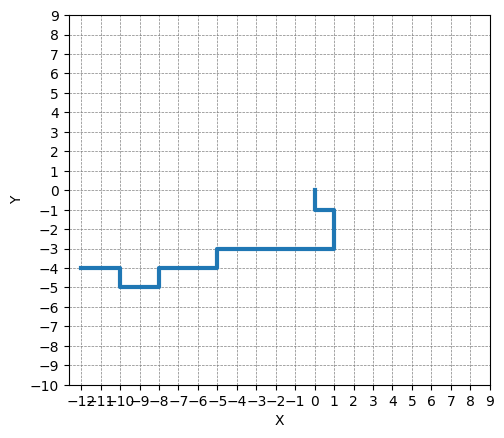

In [21]:
# Visualize one pivot operation

N = 20

saw = saw2d()
res = saw.take_steps(N)
while not res:
    saw = saw2d()
    res = saw.take_steps(N)
saw.plot_walk()
success = saw.pivot()
while not success:
  success = saw.pivot()
saw.plot_walk()


# Generate samples with pivot algorithm (dynamic)

In [3]:
def generate_samples(n_samples=100, N=100, buffer_size=100, init="rod"):
  saw_list = deque(maxlen=buffer_size)  
  omega2_list = []
  s2_list = []
  failed_count = 0
  ps_list = []

  if init == "rod":
    saw_initial = saw2d()
    saw_initial.initial_walk(length=N)
  elif init == "walk":
    saw_initial = saw2d()
    res = saw_initial.take_steps(N)
    while not res:
      saw_initial = saw2d()
      res = saw_initial.take_steps(N)

  saw_list.append(saw_initial.walked_path)
  print(' ', end='', flush=True)


  for i in trange(n_samples):
    saw_pwalk_prev = saw_list[-1]
    # ind = random.randint((int)(len(saw_list)/2), len(saw_list)-1)
    # saw_pwalk_prev = saw_list[ind] # This does not give correct distribution
    saw_curr = saw2d()
    saw_curr.set_curr_walk(saw_pwalk_prev)
    failed_count =0

    success = saw_curr.pivot()
    while not success:
      failed_count += 1
      success = saw_curr.pivot()

    saw_list.append(saw_curr.walked_path)
    omega2_list.append(saw_curr.get_omega2())
    s2_list.append(saw_curr.get_S2())
    ps_list.append(failed_count)

    i += 1
  
  print(f"N: {N}  average fails until accept {np.mean(ps_list)}")

  return saw_list, omega2_list, s2_list


In [12]:
n_samples = int(1e6)
num_discard = int(1e5)
buffer_size = int(n_samples / 10)

Ns = [15, 20]

def process_n(N):
    saw_list, omega2_list, s2_list = generate_samples(n_samples=n_samples, N=N, buffer_size=buffer_size, init="walk")
    omega2_discarded = omega2_list[num_discard:]
    s2_discarded = s2_list[num_discard:]
    n_remaining_samples = len(omega2_discarded)

    mean_omega2 = np.mean(omega2_discarded)
    mean_s2 = np.mean(s2_discarded)
    
    std_omega2 = np.std(omega2_discarded)
    std_s2 = np.std(s2_discarded)

    z_value = 1.96  # for 95% confidence interval
    
    error_omega2 = z_value * (std_omega2 / np.sqrt(n_remaining_samples))
    error_s2 = z_value * (std_s2 / np.sqrt(n_remaining_samples))
    
    print(f"N: {N}  omega^2: {mean_omega2} ± {error_omega2}  S^2: {mean_s2} ± {error_s2}")

    return (mean_omega2, error_omega2), (mean_s2, error_s2)


with Pool() as pool:
    results = list(tqdm(pool.imap(process_n, Ns), total=len(Ns)))

omega2s, error_omega2s, s2s, error_s2s = zip(*[(res[0][0], res[0][1], res[1][0], res[1][1]) for res in results])
print(f"omega^2: {omega2s}")
print(f"S^2: {s2s}")

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

N: 15  omega^2: 47.20321777777778 ± 0.06033690666122035  S^2: 6.781520347222222 ± 0.004717056021875231
N: 20  omega^2: 72.31699333333333 ± 0.0935412078641381  S^2: 10.262849584278147 ± 0.0072788553054704865
omega^2: (47.20321777777778, 72.31699333333333)
S^2: (6.781520347222222, 10.262849584278147)


## Verification of snall N results
For N= (15,20):

omega^2: (47.2032 ± 0.0603, 72.3169 ± 0.0935)

S^2: (6.7815 ± 0.0047, 10.2628± 0.0072)

In [25]:
n_samples = int(1e6)
num_discard = int(3*1e5)
buffer_size = int(n_samples / 10)

Ns = [15, 20]

def process_n(N):
    saw_list, omega2_list, s2_list = generate_samples(n_samples=n_samples, N=N, buffer_size=buffer_size, init="rod")
    # print(f"N: {N}  omega^2: {np.mean(omega2_list)} S^2: {np.mean(s2_list)}")
    omega2_discarded = omega2_list[num_discard:]
    s2_discarded = s2_list[num_discard:]
    n_remaining_samples = len(omega2_discarded)

    mean_omega2 = np.mean(omega2_discarded)
    mean_s2 = np.mean(s2_discarded)
    
    std_omega2 = np.std(omega2_discarded)
    std_s2 = np.std(s2_discarded)

    z_value = 1.96  # for 95% confidence interval
    
    error_omega2 = z_value * (std_omega2 / np.sqrt(n_remaining_samples))
    error_s2 = z_value * (std_s2 / np.sqrt(n_remaining_samples))
    
    print(f"N: {N}  omega^2: {mean_omega2} ± {error_omega2}  S^2: {mean_s2} ± {error_s2}")

    return (mean_omega2, error_omega2), (mean_s2, error_s2)


with Pool() as pool:
    results = list(tqdm(pool.imap(process_n, Ns), total=len(Ns)))

# Unzip the results into omega2s and s2s
omega2s, error_omega2s, s2s, error_s2s = zip(*[(res[0][0], res[0][1], res[1][0], res[1][1]) for res in results])

# Print the results
print(f"omega^2: {omega2s}")
print(f"S^2: {s2s}")


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

N: 15  average fails until accept 0.0
N: 15  omega^2: 48.049102857142856 ± 0.07086946006916449  S^2: 6.955004854910714 ± 0.00555844136328764
N: 20  average fails until accept 0.0
N: 20  omega^2: 76.01378857142858 ± 0.11413150018376014  S^2: 10.945040732102365 ± 0.009044620394251204
omega^2: (48.049102857142856, 76.01378857142858)
S^2: (6.955004854910714, 10.945040732102365)


## Estimating nu

In [4]:
n_samples = int(1e6)
num_discard = int(3*1e5)
buffer_size = int(n_samples / 10)

# Ns = np.array([   50, 200, 400,  800, 1600, 2400, 3000, 5000, 7000])
Ns = np.array([   20, 50, 200, 400, 600, 800, 1200, 1600, 2400])

def process_n(N):
    saw_list, omega2_list, s2_list = generate_samples(n_samples=n_samples, N=N, buffer_size=buffer_size, init="rod")
    # print(f"N: {N}  omega^2: {np.mean(omega2_list)} S^2: {np.mean(s2_list)}")
    omega2_discarded = omega2_list[num_discard:]
    s2_discarded = s2_list[num_discard:]
    n_remaining_samples = len(omega2_discarded)

    mean_omega2 = np.mean(omega2_discarded)
    mean_s2 = np.mean(s2_discarded)
    
    std_omega2 = np.std(omega2_discarded)
    std_s2 = np.std(s2_discarded)

    z_value = 1.96  # for 95% confidence interval
    
    error_omega2 = z_value * (std_omega2 / np.sqrt(n_remaining_samples))
    error_s2 = z_value * (std_s2 / np.sqrt(n_remaining_samples))
    
    print(f"N: {N}  omega^2: {mean_omega2} ± {error_omega2}  S^2: {mean_s2} ± {error_s2}")

    return (mean_omega2, error_omega2), (mean_s2, error_s2)


with Pool() as pool:
    results = list(tqdm(pool.imap(process_n, Ns), total=len(Ns)))

# Unzip the results into omega2s and s2s
omega2s, error_omega2s, s2s, error_s2s = zip(*[(res[0][0], res[0][1], res[1][0], res[1][1]) for res in results])

# Print the results
print(f"omega^2: {omega2s}")
print(f"S^2: {s2s}")



  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

N: 20  average fails until accept 0.82229
N: 20  omega^2: 75.39011714285714 ± 0.10813183638909632  S^2: 10.57532478781989 ± 0.0083834619743081
N: 50  average fails until accept 1.181766
N: 50  omega^2: 292.39953142857144 ± 0.43590449617099736  S^2: 40.47263302905474 ± 0.03397336626753028
N: 200  average fails until accept 1.873014
N: 200  omega^2: 2310.790722857143 ± 3.5071964909149766  S^2: 319.4622310504338 ± 0.2783989487461611
N: 400  average fails until accept 2.289428
N: 400  omega^2: 6532.651594285714 ± 9.946589496994463  S^2: 903.5559010169445 ± 0.7929329131855676
N: 600  average fails until accept 2.561421
N: 600  omega^2: 11948.98582 ± 18.154497863779902  S^2: 1655.9837517019218 ± 1.4476947277814132
N: 800  average fails until accept 2.780791
N: 800  omega^2: 18424.836294285713 ± 28.08750322693688  S^2: 2542.904313058499 ± 2.245302034504441
N: 1200  average fails until accept 3.084196
N: 1200  omega^2: 33818.91124857143 ± 51.543545969295764  S^2: 4676.770298173358 ± 4.12111767

In [22]:
Ns = np.array([   20, 50, 200, 400, 600, 800, 1200, 1600, 2400])
omega2s = np.array([75.39011714285714, 292.39953142857144, 2310.790722857143, 6532.651594285714, 11948.98582, 18424.836294285713, 33818.91124857143, 52228.88002857143, 96211.01888857143])
s2s = np.array([10.57532478781989, 40.47263302905474, 319.4622310504338, 903.5559010169445, 1655.9837517019218, 2542.904313058499, 4676.770298173358, 7209.936219558825, 13310.939558772097])
error_omega2s = np.array([0.10813183638909632,0.43590449617099736,3.5071964909149766,9.946589496994463,18.154497863779902,28.08750322693688,51.543545969295764,79.43968065131226,146.52309326381337])
error_s2s = np.array([0.0083834619743081,0.03397336626753028,0.2783989487461611,0.7929329131855676,1.4476947277814132,2.245302034504441,4.121117670180724,6.346051696094923,11.71445536457111])
ratio = omega2s / s2s
ratio

array([7.12887014, 7.22462339, 7.2333769 , 7.22993628, 7.21564195,
       7.24558773, 7.23125343, 7.24401415, 7.22796602])

## Results for critical exponents
| Ns   | omega^2  | S^2     | S2/omega2|
|------|----------|---------|----------|
| 20   | 75.3901  | 10.5753 | 0.140275 |
| 50   | 292.400  | 40.4726 | 0.138416 |
| 200  | 2310.79  | 319.462 | 0.138248 |
| 400  | 6532.65  | 903.556 | 0.138314 |
| 600  | 11949.0  | 1655.98 | 0.138588 |
| 800  | 18424.8  | 2542.90 | 0.138015 |
| 1200 | 33818.9  | 4676.77 | 0.138289 |
| 1600 | 52228.9  | 7209.94 | 0.138045 |
| 2400 | 96211.0  | 13310.9 | 0.138352 |


## Curve fitting 

Fitted parameters:
A = 0.8497540364530056
nu = 0.7469839432199123


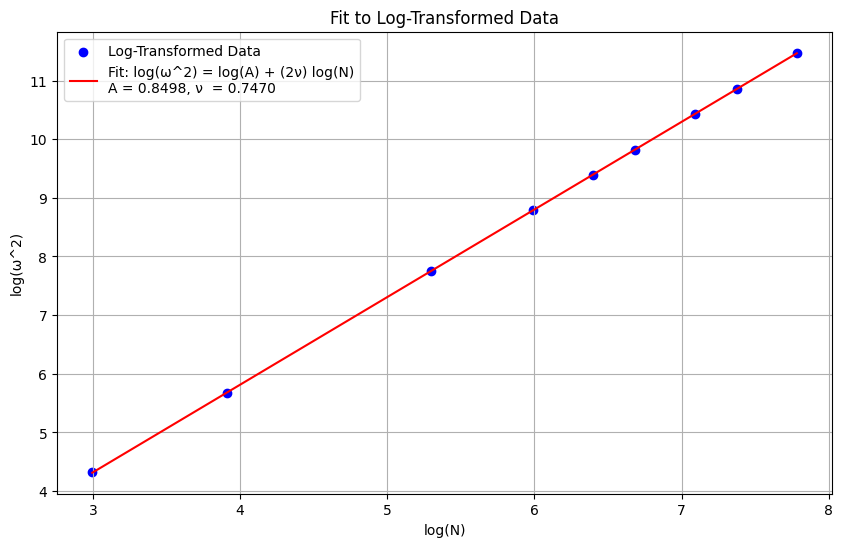

Weighted Mean Square Deviation: 8.264244563722128
Fitted parameters:
A = 0.11925378672727494
p = 1.4917535077541246


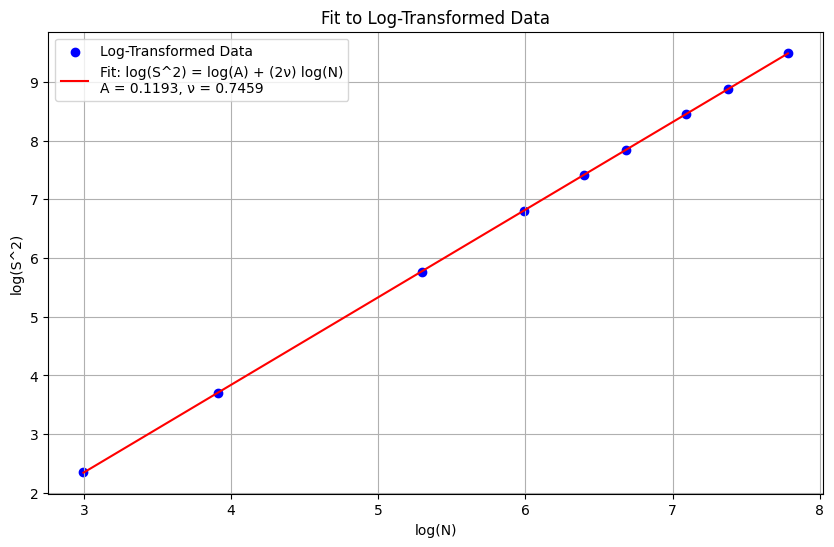

Weighted Mean Square Deviation: 7.450799718446271e-05


In [23]:
log_N = np.log(Ns)
log_mean_squared_radii = np.log(omega2s)
log_s2 = np.log(s2s)

# Perform linear regression on the log-transformed data
coefficients_omega2 = np.polyfit(log_N, log_mean_squared_radii, 1)
p = coefficients_omega2[0]
nu = p/2
log_A = coefficients_omega2[1]
A = np.exp(log_A)

print(f"Fitted parameters:\nA = {A}\nnu = {nu}")



plt.figure(figsize=(10, 6))
plt.scatter(log_N, log_mean_squared_radii, color='blue', label='Log-Transformed Data')
plt.plot(log_N, log_N * p + log_A, color='red', label=f'Fit: log(ω^2) = log(A) + (2ν) log(N)\nA = {A:.4f}, ν  = {nu:.4f}')
# plt.plot(log_N, 0.767 *+log_N * (2*0.7503), color='green', label=f'predicted')

plt.xlabel('log(N)')
plt.ylabel('log(ω^2)')
plt.title('Fit to Log-Transformed Data')
plt.legend()
plt.grid(True)
plt.show()

# fitted_values = A * Ns ** p
# residuals = Ns - fitted_values
fitted_values = log_N * p + log_A
residuals = log_N - fitted_values
weights = np.ones_like(log_N)
weighted_squared_residuals = weights * residuals**2
wmsd = np.sum(weighted_squared_residuals) / np.sum(weights)

print(f"Weighted Mean Square Deviation: {wmsd}")


''' S^2'''

coefficients_s2s = np.polyfit(log_N, log_s2, 1)
p = coefficients_s2s[0]
nu = p/2
log_A = coefficients_s2s[1]
A = np.exp(log_A)

print(f"Fitted parameters:\nA = {A}\np = {p}")



plt.figure(figsize=(10, 6))
plt.scatter(log_N, log_s2, color='blue', label='Log-Transformed Data')
plt.plot(log_N, log_N * p + log_A, color='red', label=f'Fit: log(S^2) = log(A) + (2ν) log(N)\nA = {A:.4f}, ν = {nu:.4f}')
# plt.plot(log_N, 0.1076 *+log_N * (2*0.7503), color='green', label=f'predicted')

plt.xlabel('log(N)')
plt.ylabel('log(S^2)')
plt.title('Fit to Log-Transformed Data')
plt.legend()
plt.grid(True)
plt.show()

fitted_values = log_N * p + log_A
residuals = log_s2 - fitted_values
weights = np.ones_like(log_N)
weighted_squared_residuals = weights * residuals**2
wmsd = np.sum(weighted_squared_residuals) / np.sum(weights)

print(f"Weighted Mean Square Deviation: {wmsd}")



Fitted parameters:
A = 0.9882897546530711
p = -0.19668827191982632


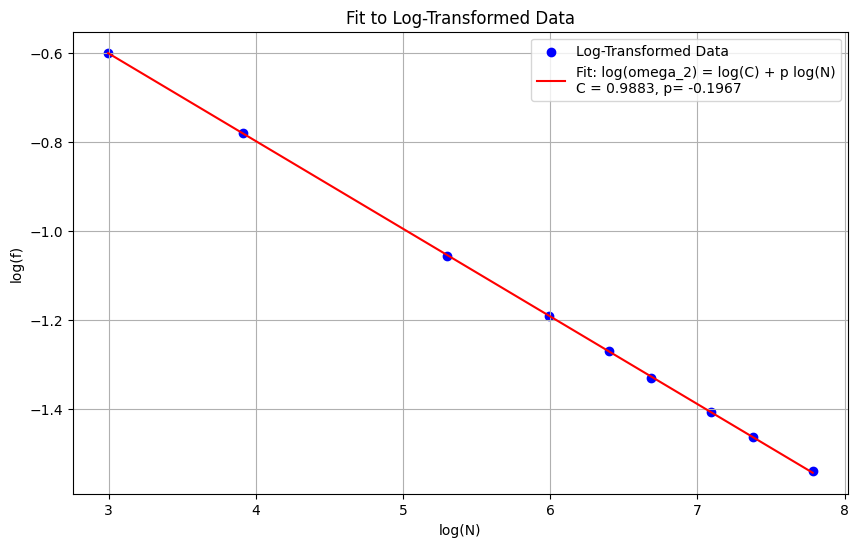

Weighted Mean Square Deviation: 3.1270417970916966e-06


In [26]:
average_fails_until_accept = np.array([0.82229, 1.181766, 1.873014, 2.289428, 2.561421, 2.780791, 3.084196, 3.313933, 3.661759])
Ns = np.array([   20, 50, 200, 400, 600, 800, 1200, 1600, 2400])
average_iterations_until_accept = average_fails_until_accept + 1
acceptance_fracs = 1/average_iterations_until_accept
log_fracs = np.log(acceptance_fracs)

coefficients_s2s = np.polyfit(log_N, log_fracs, 1)
p = coefficients_s2s[0]
log_A = coefficients_s2s[1]
A = np.exp(log_A)

print(f"Fitted parameters:\nA = {A}\np = {p}")

plt.figure(figsize=(10, 6))
plt.scatter(log_N, log_fracs, color='blue', label='Log-Transformed Data')
plt.plot(log_N, log_N * p + log_A, color='red', label=f'Fit: log(omega_2) = log(C) + p log(N)\nC = {A:.4f}, p= {p:.4f}')

plt.xlabel('log(N)')
plt.ylabel('log(f)')
plt.title('Fit to Log-Transformed Data')
plt.legend()
plt.grid(True)
plt.show()

fitted_values = log_N * p + log_A
residuals = log_fracs - fitted_values
weights = np.ones_like(log_N)
weighted_squared_residuals = weights * residuals**2
wmsd = np.sum(weighted_squared_residuals) / np.sum(weights)

print(f"Weighted Mean Square Deviation: {wmsd}")


# 3-dimensional saw


In [2]:
# Generate the transformations for 3D - 48 elements in Octahedral symmetry group
# Generation code by gpt4
I = np.eye(3)

# 90-degree rotations
R_x_90 = np.array([[1, 0, 0],
                   [0, 0, -1],
                   [0, 1, 0]])
R_y_90 = np.array([[0, 0, 1],
                   [0, 1, 0],
                   [-1, 0, 0]])
R_z_90 = np.array([[0, -1, 0],
                   [1, 0, 0],
                   [0, 0, 1]])

R_x_180 = np.linalg.matrix_power(R_x_90, 2)
R_y_180 = np.linalg.matrix_power(R_y_90, 2)
R_z_180 = np.linalg.matrix_power(R_z_90, 2)

R_x_270 = np.linalg.matrix_power(R_x_90, 3)
R_y_270 = np.linalg.matrix_power(R_y_90, 3)
R_z_270 = np.linalg.matrix_power(R_z_90, 3)

# Reflections
M_x = np.array([[-1, 0, 0],
                [0, 1, 0],
                [0, 0, 1]])
M_y = np.array([[1, 0, 0],
                [0, -1, 0],
                [0, 0, 1]])
M_z = np.array([[1, 0, 0],
                [0, 1, 0],
                [0, 0, -1]])

# Improper 90-degree rotations
R_x_90_prime = np.dot(M_x, R_x_90)
R_y_90_prime = np.dot(M_y, R_y_90)
R_z_90_prime = np.dot(M_z, R_z_90)

# Improper 180-degree rotations
R_x_180_prime = np.dot(M_x, R_x_180)
R_y_180_prime = np.dot(M_y, R_y_180)
R_z_180_prime = np.dot(M_z, R_z_180)

# Improper 270-degree rotations
R_x_270_prime = np.dot(M_x, R_x_270)
R_y_270_prime = np.dot(M_y, R_y_270)
R_z_270_prime = np.dot(M_z, R_z_270)

# Combine the matrices into the full group
matrices = [I,
            R_x_90, R_x_270, R_y_90, R_y_270, R_z_90, R_z_270,
            R_x_180, R_y_180, R_z_180,
            M_x, M_y, M_z,
            R_x_90_prime, R_y_90_prime, R_z_90_prime,
            R_x_180_prime, R_y_180_prime, R_z_180_prime,
            R_x_270_prime, R_y_270_prime, R_z_270_prime,
            ]

# Add all 48 unique matrices

# Generate all 24 different rotation matrices using normal rotations
# need to convert to hashable tuples
rotation_matrix_set = set(map(tuple, [tuple(map(tuple, rotate)) for rotate in [I, R_x_90, R_x_180, R_x_270, R_y_90, R_y_180, R_y_270, R_z_90, R_z_180, R_z_270]]))
while len(rotation_matrix_set) < 24:
    new_rotations = []
    for R1 in rotation_matrix_set:
        for R2 in [I, R_x_90, R_x_180, R_x_270, R_y_90, R_y_180, R_y_270, R_z_90, R_z_180, R_z_270]:
            new_rotation = np.dot(np.array(R1), R2)
            if tuple(map(tuple, new_rotation)) not in rotation_matrix_set:
                new_rotations.append(new_rotation)
    rotation_matrix_set.update(map(tuple, [tuple(map(tuple, rotate)) for rotate in new_rotations]))

# Generate all 24 different improper rotation matrices using reflections and rotations
improper_rotation_matrix_set = set()

for reflection in [M_x, M_y, M_z]:
    for rotation in rotation_matrix_set:
        improper_rotation = np.dot(reflection, np.array(rotation))
        improper_rotation_matrix_set.add(tuple(map(tuple, improper_rotation)))

# Combine rotations and improper rotations
transformations_group = list(rotation_matrix_set) + list(improper_rotation_matrix_set)
transformations_mat_group = [np.array(tup) for tup in transformations_group]
print(f'Total number of matrices: {len(transformations_mat_group)}')

# Print all the matrices
for matrix in transformations_mat_group:
    print(matrix)
    print()


Total number of matrices: 48
[[ 0  0  1]
 [-1  0  0]
 [ 0 -1  0]]

[[-1  0  0]
 [ 0  0  1]
 [ 0  1  0]]

[[ 0  1  0]
 [ 1  0  0]
 [ 0  0 -1]]

[[0 1 0]
 [0 0 1]
 [1 0 0]]

[[-1  0  0]
 [ 0  0 -1]
 [ 0 -1  0]]

[[ 1  0  0]
 [ 0  0  1]
 [ 0 -1  0]]

[[ 0  0  1]
 [ 0  1  0]
 [-1  0  0]]

[[ 0  0 -1]
 [ 1  0  0]
 [ 0 -1  0]]

[[ 0  1  0]
 [ 0  0 -1]
 [-1  0  0]]

[[ 1  0  0]
 [ 0  0 -1]
 [ 0  1  0]]

[[ 0 -1  0]
 [ 0  0  1]
 [-1  0  0]]

[[ 0  0 -1]
 [-1  0  0]
 [ 0  1  0]]

[[-1  0  0]
 [ 0  1  0]
 [ 0  0 -1]]

[[ 0  0  1]
 [ 0 -1  0]
 [ 1  0  0]]

[[ 0 -1  0]
 [-1  0  0]
 [ 0  0 -1]]

[[ 0 -1  0]
 [ 0  0 -1]
 [ 1  0  0]]

[[ 0  1  0]
 [-1  0  0]
 [ 0  0  1]]

[[ 1  0  0]
 [ 0 -1  0]
 [ 0  0 -1]]

[[ 0  0 -1]
 [ 0 -1  0]
 [-1  0  0]]

[[ 0 -1  0]
 [ 1  0  0]
 [ 0  0  1]]

[[ 0  0 -1]
 [ 0  1  0]
 [ 1  0  0]]

[[-1  0  0]
 [ 0 -1  0]
 [ 0  0  1]]

[[1. 0. 0.]
 [0. 1. 0.]
 [0. 0. 1.]]

[[0 0 1]
 [1 0 0]
 [0 1 0]]

[[ 1  0  0]
 [ 0 -1  0]
 [ 0  0  1]]

[[-1  0  0]
 [ 0  0  1]
 [ 0 -1  0]]

[

In [3]:
# SAW of 3 dimensions
class saw3d():
  def __init__(self):
    self.walked_path = np.array([[0, 0, 0]])
    self.curr_pos = np.array([0, 0, 0])
    self.possible_moves = np.array([[1,  0, 0],
                                    [-1, 0, 0],
                                    [0,  0, 1],
                                    [0, 0, -1],
                                    [0,  1, 0],
                                    [0, -1, 0]])
    self.possible_trasforms = transformations_mat_group

  def step(self):
    '''Takes one step in a random direction, and checks if the resulting walk is valid.
    Returns false if new walk is invalid, and does not take step.
    Returns True and takes a step if the step is valid'''

    next_moves = self.curr_pos + self.possible_moves  
    next_pos = next_moves[np.random.choice(len(next_moves))]
    if np.any(np.all(self.walked_path == next_pos, axis=1)):
      return False
    self.curr_pos = next_pos
    self.walked_path = np.vstack([self.walked_path, self.curr_pos])
    return True

  def take_steps(self, N):
    for n in range(N):
      if not self.step():
        return False
    return True

  def plot_walk(self, min_range=-10, max_range=10):
    N = len(self.walked_path)
    x = self.walked_path[:, 0]
    y = self.walked_path[:, 1]
    z = self.walked_path[:, 2]

    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')

    ax.plot(x, y, z, marker='', linestyle='-', linewidth=2)
    ax.set_box_aspect(aspect=(1, 1, 1))

    ax_rangex = np.arange(min(min_range, min(x)), max(max_range, max(x)), step=1)
    ax_rangey = np.arange(min(min_range, min(y)), max(max_range, max(y)), step=1)
    ax_rangez = np.arange(min(min_range, min(z)), max(max_range, max(z)), step=1)

    ax.set_xticks(ax_rangex)
    ax.set_yticks(ax_rangey)
    ax.set_zticks(ax_rangez)
    plt.show()
  
  def initial_walk(self, length):
    '''generate straight line walk for initial step'''
    self.walked_path = np.array([[i, 0, 0] for i in range(length+1)])
    self.curr_pos = self.walked_path[-1]
    return
  
  def set_curr_walk(self, new_path):
    self.walked_path = new_path
    self.current_pos = self.walked_path[-1]

  def get_omega2(self):
    # gets current squared end-to-end distance
    start = self.walked_path[0]
    end = self.walked_path[-1]
    omega2 = np.sum((end - start) ** 2)
    return omega2

  def get_S2(self):
    # gets current squared radius of gyration
    N = len(self.walked_path) - 1  
    path_squared = np.sum(self.walked_path ** 2, axis=1)
    total_squared_sum = np.sum(path_squared)
    total_sum = np.sum(self.walked_path, axis=0)
    squared_total_sum = np.sum(total_sum ** 2)

    S_squared = (1 / (N + 1)) * total_squared_sum - (1 / (N + 1) ** 2) * squared_total_sum
    return S_squared

  def pivot(self):
    '''Attempts to perform one pivot on the current path.
    Returns True if pivot successful and modifies the current path
    Returns False if pivot uncesseful and does not modify self'''
    
    if len(self.walked_path) < 3:
      print("error: path length < 3")
      return False 

    pivot_index = random.randint(1, len(self.walked_path) - 1)
    pivot_point = self.walked_path[pivot_index]
    transformation = random.choice(self.possible_trasforms)

    new_path = np.empty_like(self.walked_path)
    new_path[:pivot_index + 1] = self.walked_path[:pivot_index + 1]

    vectors = self.walked_path[pivot_index+1:] - pivot_point
    transformed_vecs = vectors @ transformation.T
    new_points = transformed_vecs + pivot_point
    new_path[pivot_index+1:] = new_points

    if self.is_valid_walk(new_path):
      # print("pivot success")
      self.walked_path = new_path
      self.current_pos = self.walked_path[-1]
      return True
    else:
      # print("pivot failed")
      return False

  def is_valid_walk(self, path):
    # check if pivoted walk is saw
    return len(path) == len(set(tuple(p) for p in path))




## Naive Generation & Visualization

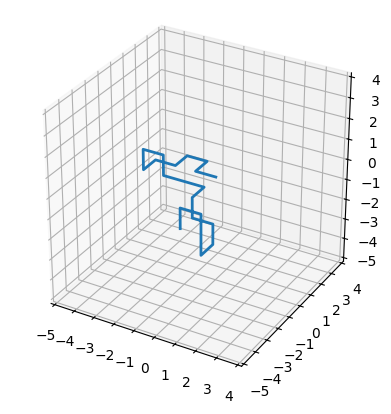

In [ ]:
# Show naive generation of one walk
N = 20
saw = saw3d()
saw.take_steps(N)
saw.plot_walk(-5,5)

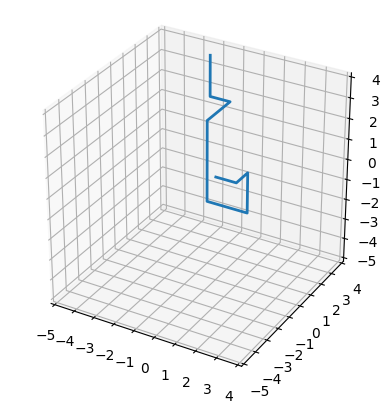

pivot point: [-1  1  2]
pivot operation: [[ 0  1  0]
 [ 0  0  1]
 [-1  0  0]]


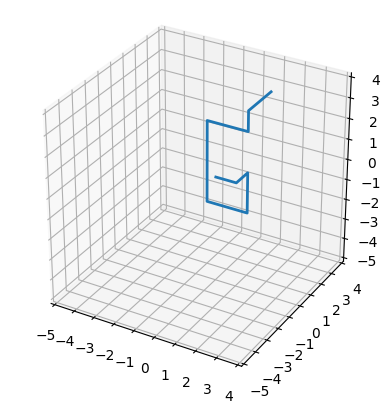

In [38]:
# Show one pivot performed on one walk

N = 15

saw = saw3d()
res = saw.take_steps(N)
while not res:
    saw = saw3d()
    res = saw.take_steps(N)
saw.plot_walk(-5,5)
success = saw.pivot()
while not success:
  success = saw.pivot()
saw.plot_walk(-5,5)


## Critical Exponents

In [4]:
def generate_samples_3d(n_samples=100, N=100, use_pivot=True, buffer_size=100, init="rod"):
  saw_list = deque(maxlen=buffer_size)  
  omega2_list = []
  s2_list = []
  failed_count = 0
  ps_list = []

  if init == "rod":
    saw_initial = saw3d()
    saw_initial.initial_walk(length=N)
  elif init == "walk":
    saw_initial = saw3d()
    res = saw_initial.take_steps(N)
    while not res:
      saw_initial = saw3d()
      res = saw_initial.take_steps(N)

  saw_list.append(saw_initial.walked_path)
  print(' ', end='', flush=True)


  for i in trange(n_samples):
    saw_pwalk_prev = saw_list[-1]
    saw_curr = saw3d()
    saw_curr.set_curr_walk(saw_pwalk_prev)
    failed_count =0

    success = saw_curr.pivot()
    while not success:
      failed_count += 1
      success = saw_curr.pivot()

    saw_list.append(saw_curr.walked_path)
    omega2_list.append(saw_curr.get_omega2())
    s2_list.append(saw_curr.get_S2())
    ps_list.append(failed_count)

    i += 1
  
  print(f"N: {N}  average fails until accept {np.mean(ps_list)}")

  return saw_list, omega2_list, s2_list



In [28]:
# Generate samples for Ns = [15, 20]

n_samples = int(1e6)
num_discard = int(1e5)
buffer_size = int(n_samples / 10)

Ns = [15, 20]

def process_n(N):
    saw_list, omega2_list, s2_list = generate_samples_3d(n_samples=n_samples, N=N, buffer_size=buffer_size, init="walk")
    omega2_discarded = omega2_list[num_discard:]
    s2_discarded = s2_list[num_discard:]
    n_remaining_samples = len(omega2_discarded)

    mean_omega2 = np.mean(omega2_discarded)
    mean_s2 = np.mean(s2_discarded)
    
    std_omega2 = np.std(omega2_discarded)
    std_s2 = np.std(s2_discarded)

    z_value = 1.96  # for 95% confidence interval
    
    error_omega2 = z_value * (std_omega2 / np.sqrt(n_remaining_samples))
    error_s2 = z_value * (std_s2 / np.sqrt(n_remaining_samples))
    
    print(f"N: {N}  omega^2: {mean_omega2} ± {error_omega2}  S^2: {mean_s2} ± {error_s2}")

    return (mean_omega2, error_omega2), (mean_s2, error_s2)


with Pool() as pool:
    results = list(tqdm(pool.imap(process_n, Ns), total=len(Ns)))

# Unzip the results into omega2s and s2s
omega2s, error_omega2s, s2s, error_s2s = zip(*[(res[0][0], res[0][1], res[1][0], res[1][1]) for res in results])

# Print the results
print(f"omega^2: {omega2s}")
print(f"S^2: {s2s}")


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

N: 15  average fails until accept 0.336899
N: 15  omega^2: 27.966033333333332 ± 0.03624293774916507  S^2: 4.465631041666667 ± 0.0031937822034472443
N: 20  average fails until accept 0.380253
N: 20  omega^2: 39.70646444444444 ± 0.05245318181711643  S^2: 6.289374759385237 ± 0.004649728276369395
omega^2: (27.966033333333332, 39.70646444444444)
S^2: (4.465631041666667, 6.289374759385237)


In [5]:
# Generate samples for various N values

n_samples = int(1e6)
num_discard = int(3*1e5)
buffer_size = int(n_samples / 10)

Ns = np.array([   20, 50, 200, 400, 600, 800, 1200, 1600, 2400])

def process_n(N):
    saw_list, omega2_list, s2_list = generate_samples_3d(n_samples=n_samples, N=N, buffer_size=buffer_size, init="rod")

    omega2_discarded = omega2_list[num_discard:]
    s2_discarded = s2_list[num_discard:]
    n_remaining_samples = len(omega2_discarded)

    mean_omega2 = np.mean(omega2_discarded)
    mean_s2 = np.mean(s2_discarded)
    std_omega2 = np.std(omega2_discarded)
    std_s2 = np.std(s2_discarded)

    z_value = 1.96  # for 95% confidence interval
    
    error_omega2 = z_value * (std_omega2 / np.sqrt(n_remaining_samples))
    error_s2 = z_value * (std_s2 / np.sqrt(n_remaining_samples))
    
    print(f"N: {N}  omega^2: {mean_omega2} ± {error_omega2}  S^2: {mean_s2} ± {error_s2}")
    return (mean_omega2, error_omega2), (mean_s2, error_s2)


with Pool() as pool:
    results = list(tqdm(pool.imap(process_n, Ns), total=len(Ns)))

omega2s, error_omega2s, s2s, error_s2s = zip(*[(res[0][0], res[0][1], res[1][0], res[1][1]) for res in results])

print(f"omega^2: {omega2s}")
print(f"S^2: {s2s}")


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

  0%|          | 0/1000000 [00:00<?, ?it/s]

N: 20  average fails until accept 0.379387
N: 20  omega^2: 39.58027714285714 ± 0.05938335895438112  S^2: 6.275065714285713 ± 0.0052742923792334605
N: 50  average fails until accept 0.525066
N: 50  omega^2: 119.38668285714286 ± 0.18779147839555327  S^2: 18.77678642719832 ± 0.01714777091455261
N: 200  average fails until accept 0.775897
N: 200  omega^2: 619.79454 ± 1.0057661617830866  S^2: 98.03412346490711 ± 0.09395954698415063
N: 400  average fails until accept 0.912941
N: 400  omega^2: 1420.91914 ± 2.3254916935550276  S^2: 224.31797538977622 ± 0.2182548272284781
N: 600  average fails until accept 1.001148
N: 600  omega^2: 2286.489242857143 ± 3.7528653708316466  S^2: 361.70904786526853 ± 0.3548980513008073
N: 800  average fails until accept 1.064773
N: 800  omega^2: 3202.8898057142856 ± 5.261012204206891  S^2: 508.29805635013946 ± 0.5012274685858504
N: 1200  average fails until accept 1.160778
N: 1200  omega^2: 5148.6899 ± 8.486823557435477  S^2: 817.469260644719 ± 0.8064221527115056
N

In [29]:
# Results from above block
omega2s = np.array([39.58027714285714, 119.38668285714286, 619.79454, 1420.91914, 2286.489242857143, 3202.8898057142856, 5148.6899, 7250.812437142858, 11659.786311428572])
s2s = np.array([6.275065714285713, 18.77678642719832, 98.03412346490711, 224.31797538977622, 361.70904786526853, 508.29805635013946, 817.469260644719, 1153.091086012163, 1853.9809924211036])

### Curve Fits for 3D

Fitted parameters:
A = 1.1434885283450023
nu = 0.5935744200198002


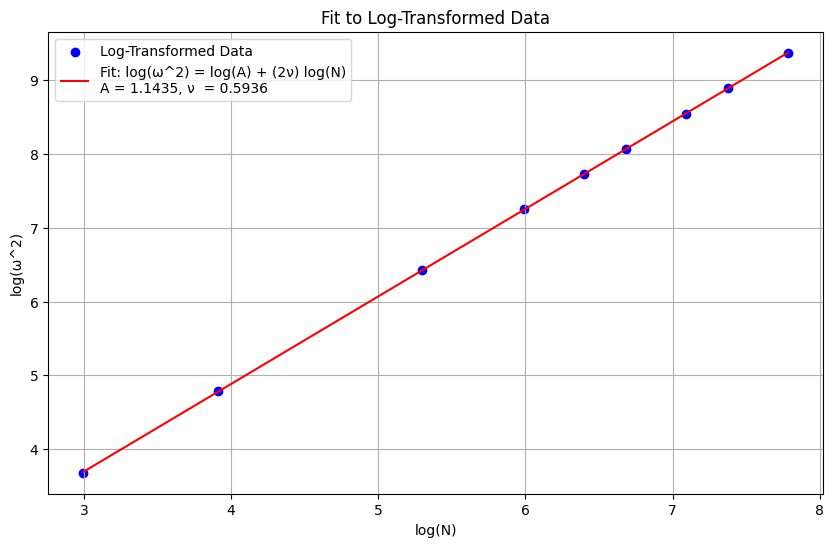

Weighted Mean Square Deviation: 1.636258533492269
Fitted parameters:
A = 0.17963126617465391
nu = 0.5942693442530211


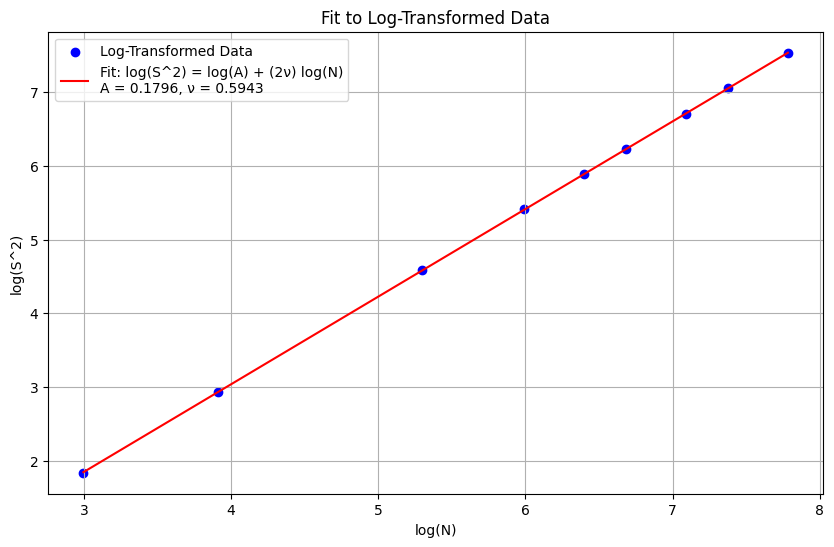

Weighted Mean Square Deviation: 3.075117724667627e-05


In [25]:
log_N = np.log(Ns)
log_mean_squared_radii = np.log(omega2s)
log_s2 = np.log(s2s)

# Perform linear regression on the log-transformed data
coefficients_omega2 = np.polyfit(log_N, log_mean_squared_radii, 1)
p = coefficients_omega2[0]
nu = p/2
log_A = coefficients_omega2[1]
A = np.exp(log_A)

print(f"Fitted parameters:\nA = {A}\nnu = {nu}")



plt.figure(figsize=(10, 6))
plt.scatter(log_N, log_mean_squared_radii, color='blue', label='Log-Transformed Data')
plt.plot(log_N, log_N * p + log_A, color='red', label=f'Fit: log(ω^2) = log(A) + (2ν) log(N)\nA = {A:.4f}, ν  = {nu:.4f}')
# plt.plot(log_N, 0.767 *+log_N * (2*0.7503), color='green', label=f'predicted')

plt.xlabel('log(N)')
plt.ylabel('log(ω^2)')
plt.title('Fit to Log-Transformed Data')
plt.legend()
plt.grid(True)
plt.show()

# fitted_values = A * Ns ** p
# residuals = Ns - fitted_values
fitted_values = log_N * p + log_A
residuals = log_N - fitted_values
weights = np.ones_like(log_N)
weighted_squared_residuals = weights * residuals**2
wmsd = np.sum(weighted_squared_residuals) / np.sum(weights)

print(f"Weighted Mean Square Deviation: {wmsd}")


''' S^2'''

coefficients_s2s = np.polyfit(log_N, log_s2, 1)
p = coefficients_s2s[0]
nu = p/2
log_A = coefficients_s2s[1]
A = np.exp(log_A)

print(f"Fitted parameters:\nA = {A}\nnu = {nu}")



plt.figure(figsize=(10, 6))
plt.scatter(log_N, log_s2, color='blue', label='Log-Transformed Data')
plt.plot(log_N, log_N * p + log_A, color='red', label=f'Fit: log(S^2) = log(A) + (2ν) log(N)\nA = {A:.4f}, ν = {nu:.4f}')
# plt.plot(log_N, 0.1076 *+log_N * (2*0.7503), color='green', label=f'predicted')

plt.xlabel('log(N)')
plt.ylabel('log(S^2)')
plt.title('Fit to Log-Transformed Data')
plt.legend()
plt.grid(True)
plt.show()

fitted_values = log_N * p + log_A
residuals = log_s2 - fitted_values
weights = np.ones_like(log_N)
weighted_squared_residuals = weights * residuals**2
wmsd = np.sum(weighted_squared_residuals) / np.sum(weights)

print(f"Weighted Mean Square Deviation: {wmsd}")



Fitted parameters:
A = 1.0054152789280533
p = -0.10926915613050649


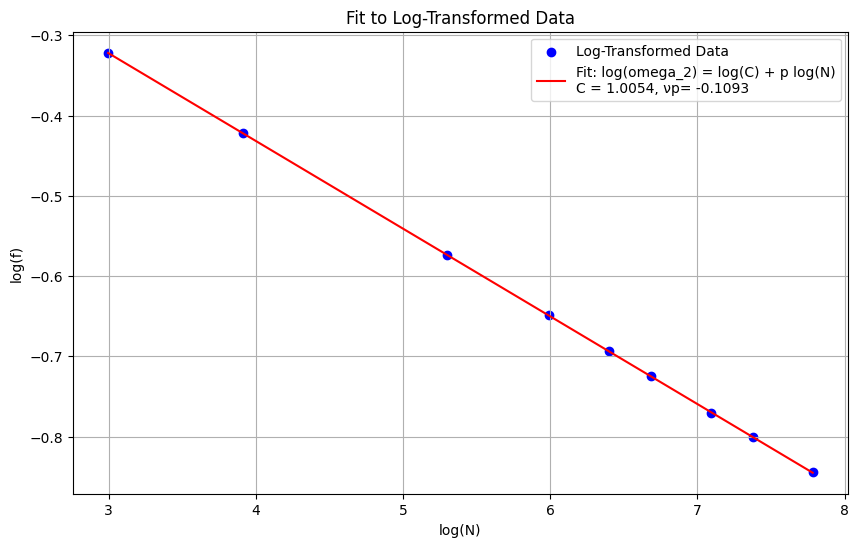

Weighted Mean Square Deviation: 3.325382996619179e-07


In [31]:
average_fails_until_accept = np.array([0.379387, 0.525066, 0.775897, 0.912941, 1.001148, 1.064773, 1.160778, 1.226196, 1.326718])
Ns = np.array([   20, 50, 200, 400, 600, 800, 1200, 1600, 2400])
average_iterations_until_accept = average_fails_until_accept + 1
acceptance_fracs = 1/average_iterations_until_accept
log_fracs = np.log(acceptance_fracs)

coefficients_s2s = np.polyfit(log_N, log_fracs, 1)
p = coefficients_s2s[0]
log_A = coefficients_s2s[1]
A = np.exp(log_A)

print(f"Fitted parameters:\nA = {A}\np = {p}")

plt.figure(figsize=(10, 6))
plt.scatter(log_N, log_fracs, color='blue', label='Log-Transformed Data')
plt.plot(log_N, log_N * p + log_A, color='red', label=f'Fit: log(omega_2) = log(C) + p log(N)\nC = {A:.4f}, νp= {p:.4f}')

plt.xlabel('log(N)')
plt.ylabel('log(f)')
plt.title('Fit to Log-Transformed Data')
plt.legend()
plt.grid(True)
plt.show()

fitted_values = log_N * p + log_A
residuals = log_fracs - fitted_values
weights = np.ones_like(log_N)
weighted_squared_residuals = weights * residuals**2
wmsd = np.sum(weighted_squared_residuals) / np.sum(weights)

print(f"Weighted Mean Square Deviation: {wmsd}")
